Overall goal:

* Increase awareness of what kinds of modeling decisions we can make
  * Model choice: kNN vs LinReg
  * Hyperparameters: number of neighbors
  * Feature engineering:
    * one-hot encode a categorical feature
    * binning continuous features


Strategy: we do it together for one dataset, you do it alone for another.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set some display settings.
%matplotlib inline
sns.set(context='notebook')

In [34]:
all_training_data = pd.read_csv('data/ames_train_cleaned.csv')
# per recommendations of the original dataset authors:
all_training_data = all_training_data.query("Sale_Condition == 'Normal'").query("Gr_Liv_Area < 4000")
all_training_data['Age'] = all_training_data['Yr_Sold'] - all_training_data['Year_Built']
all_training_data["Full_Bath_total"] = all_training_data['Full_Bath'] + all_training_data['Bsmt_Full_Bath']
all_training_data["Half_Bath_total"] = all_training_data['Half_Bath'] + all_training_data['Bsmt_Half_Bath']
all_neighborhoods = list(all_training_data["Neighborhood"].unique())

In [35]:
# Hold out a validation set to measure on
training_data, validation_data = train_test_split(all_training_data, test_size=.2, random_state=0)
print(len(training_data), "observations in training set")
print(len(validation_data), "observations in validation set")
training_data.head()

1306 observations in training set
327 observations in validation set


,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms,Age,Full_Bath_total,Half_Bath_total
1674,2476,531376030,60,RL,65.0,7800,Pave,NaN,Reg,Lvl,...,0,4,2006,WD,Normal,178000,2.5,1,2.0,1.0
726,1080,528190010,120,RM,59.0,8198,Pave,NaN,Reg,Lvl,...,0,7,2008,WD,Normal,214900,3.0,4,3.0,0.0
1997,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,11,2006,WD,Normal,193900,2.5,13,2.0,1.0
657,976,923226270,180,RM,21.0,1526,Pave,NaN,Reg,Lvl,...,0,5,2009,WD,Normal,76700,2.0,39,2.0,0.0
664,987,923400110,60,RL,62.0,10429,Pave,NaN,Reg,Lvl,...,0,7,2009,WD,Normal,120900,1.5,17,1.0,1.0


In [36]:
' '.join(training_data.columns)

'Order PID MS_SubClass MS_Zoning Lot_Frontage Lot_Area Street Alley Lot_Shape Land_Contour Utilities Lot_Config Land_Slope Neighborhood Condition_1 Condition_2 Bldg_Type House_Style Overall_Qual Overall_Cond Year_Built Year_Remod/Add Roof_Style Roof_Matl Exterior_1st Exterior_2nd Mas_Vnr_Type Mas_Vnr_Area Exter_Qual Exter_Cond Foundation Bsmt_Qual Bsmt_Cond Bsmt_Exposure BsmtFin_Type_1 BsmtFin_SF_1 BsmtFin_Type_2 BsmtFin_SF_2 Bsmt_Unf_SF Total_Bsmt_SF Heating Heating_QC Central_Air Electrical 1st_Flr_SF 2nd_Flr_SF Low_Qual_Fin_SF Gr_Liv_Area Bsmt_Full_Bath Bsmt_Half_Bath Full_Bath Half_Bath Bedroom_AbvGr Kitchen_AbvGr Kitchen_Qual TotRms_AbvGrd Functional Fireplaces Fireplace_Qu Garage_Type Garage_Yr_Blt Garage_Finish Garage_Cars Garage_Area Garage_Qual Garage_Cond Paved_Drive Wood_Deck_SF Open_Porch_SF Enclosed_Porch 3Ssn_Porch Screen_Porch Pool_Area Pool_QC Fence Misc_Feature Misc_Val Mo_Sold Yr_Sold Sale_Type Sale_Condition SalePrice TotalBathrooms Age Full_Bath_total Half_Bath_tota

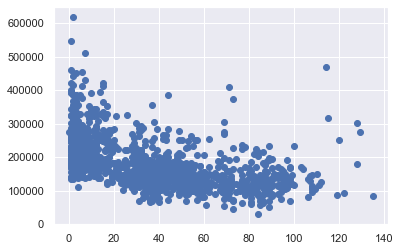

In [65]:
plt.scatter(training_data.Age, training_data.SalePrice)

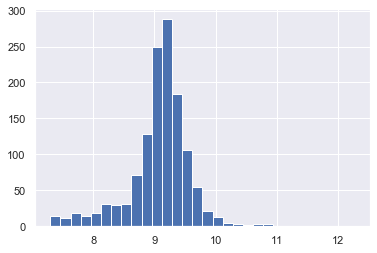

In [69]:
np.log(training_data.Lot_Area).hist(bins=30)

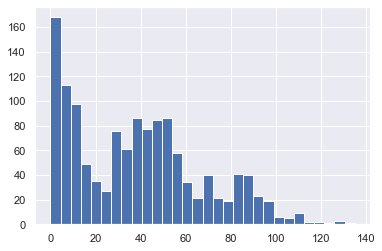

In [73]:
training_data.Age.hist(bins=30)

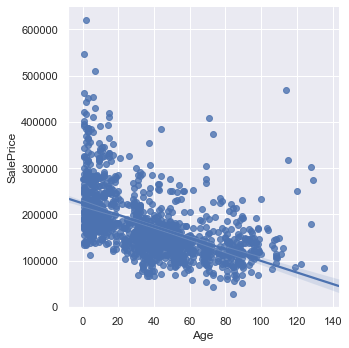

In [66]:
sns.lmplot(x="Age", y="SalePrice", data=training_data)

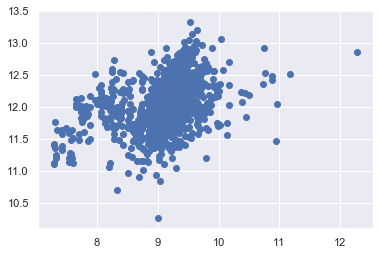

In [38]:
plt.scatter(np.log(training_data.Lot_Area), np.log(training_data.SalePrice))

In [76]:
def try_model(model_type, n_features, include_neighborhood, bin_age=True, n_neighbors=None):
    '''
    use the global training_data and validation_data
    '''

    # Which numeric features to use?
    if n_features == 1:
        numeric_features = ["Gr_Liv_Area"]
    elif n_features == 2:
        numeric_features = ["Gr_Liv_Area", "Total_Bsmt_SF"]
    elif n_features == 3:
        numeric_features = ["Gr_Liv_Area", "Total_Bsmt_SF", "Full_Bath_total"]#, "Half_Bath_total"]
    else:
        raise ValueError(f"Unknown n_features {n_features}")


    # Transform the data
    def transform(data):
        X = data[numeric_features].copy()
        
        if include_neighborhood:
            # One-hot encode Neighborhood
            for neighborhood in all_neighborhoods:
                X[f'neighborhood_{neighborhood}'] = data['Neighborhood'] == neighborhood

        if bin_age:
            X['age<5'] = data["Age"] < 5
            X['age_5-25'] = data["Age"].between(5, 25)
                
        y = data['SalePrice']
        return X, y
    
    train_X, train_y = transform(training_data)
    valid_X, valid_y = transform(validation_data)
    
    # Create a model instance of the requested type
    if model_type == "knn":
        assert n_neighbors is not None
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    elif model_type == "linreg":
        assert n_neighbors is None
        model = LinearRegression()
    else:
        raise ValueError(f"Unknown model_type {model_type}")

    # Fit the model on the training set.
    model.fit(train_X, train_y)
    
    # Get model predictions on training and validation sets.
    train_y_pred = model.predict(train_X)
    valid_y_pred = model.predict(valid_X)
    
    # Compute accuracy scores
    
    return {
        "model_type": model_type,
        "n_features": n_features,
        "n_neighbors": n_neighbors,
        "include_neighborhood": include_neighborhood,
        "train_r2": metrics.r2_score(train_y, train_y_pred),
        "valid_r2": metrics.r2_score(valid_y, valid_y_pred)
    }

scores = []
for n_features in [1, 2, 3]:
    for include_neighborhood in [True, False]:
        for n_neighbors in [5, 10, 15, 20, 25]:
            scores.append(try_model(model_type="knn", n_neighbors=n_neighbors,
                                    n_features=n_features, include_neighborhood=include_neighborhood))
        scores.append(try_model(model_type="linreg",
                                n_features=n_features, include_neighborhood=include_neighborhood))

scores_df = pd.DataFrame(scores)

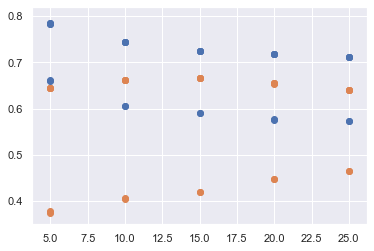

In [77]:
plt.scatter(scores_df.n_neighbors, scores_df.train_r2)
plt.scatter(scores_df.n_neighbors, scores_df.valid_r2)

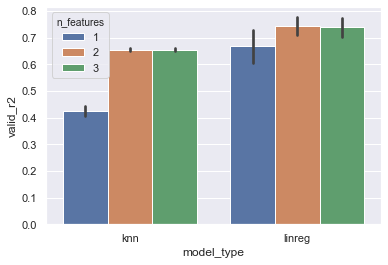

In [78]:
sns.barplot(x="model_type", y="valid_r2", hue="n_features", data=scores_df)

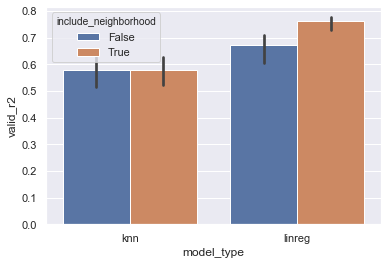

In [79]:
sns.barplot(x='model_type', y='valid_r2', hue="include_neighborhood", data=scores_df)

In [80]:
scores_df[scores_df.n_features == 3]

,include_neighborhood,model_type,n_features,n_neighbors,train_r2,valid_r2
24,True,knn,3,5.0,0.784869,0.644833
25,True,knn,3,10.0,0.744744,0.662855
26,True,knn,3,15.0,0.725514,0.666287
27,True,knn,3,20.0,0.717636,0.655080
28,True,knn,3,25.0,0.712588,0.640719
29,True,linreg,3,NaN,0.819153,0.774550
30,False,knn,3,5.0,0.784057,0.644897
31,False,knn,3,10.0,0.744872,0.662015
32,False,knn,3,15.0,0.725395,0.666091
33,False,knn,3,20.0,0.717558,0.654789
